# Cross Validation Notebook
Cross Validation or Out of Folds (OOF) scores notebook is used to tweak the various thresholds and test the Test-Time Augmentations (TTA)  
Designed for multi model/fold ensemble evaluations.  
  
Find the deployed version of the notebook on Colab: https://colab.research.google.com/drive/1XZtml9hbHxCMdO9zbyzfJ1IecQpND_Pt?usp=sharing

## 1. Setup

In [ ]:
import os
os.environ['KAGGLE_USERNAME']="abc"
os.environ['KAGGLE_KEY']="xyz"

In [ ]:
# My best public weights for GWD
!kaggle datasets download -d ii5m0k3ii/42mixup50
!unzip 42mixup50.zip -d saves
!rm -rf 42mixup50.zip

In [ ]:
#Necessary for Colab
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade --force-reinstall --no-deps albumentations

In [ ]:
#Necessary imports
!kaggle datasets download -d shonenkov/omegaconf
!unzip omegaconf.zip -d omegaconf
!rm -rf omegaconf.zip

!kaggle datasets download -d kaushal2896/pycocotools
!unzip pycocotools.zip -d pycocotools
!rm -rf pycocotools.zip

!kaggle datasets download -d greatgamedota/timm-package
!unzip timm-package.zip -d timm-package
!rm -rf timm-package.zip

!kaggle datasets download -d shonenkov/timm-efficientdet-pytorch
!unzip timm-efficientdet-pytorch.zip -d timm-efficientdet-pytorch
!rm -rf timm-efficientdet-pytorch.zip

!kaggle datasets download -d shonenkov/weightedboxesfusion
!unzip weightedboxesfusion.zip -d weightedboxesfusion
!rm -rf weightedboxesfusion.zip

!kaggle competitions download -c global-wheat-detection
!unzip global-wheat-detection.zip -d global-wheat-detection
!rm -rf global-wheat-detection.zip

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
!nvidia-smi

Sun Aug  2 14:35:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --no-deps './timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install pycocotools

In [ ]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch")
sys.path.insert(0, "./omegaconf")
sys.path.insert(0, "./weightedboxesfusion")

import os
from ensemble_boxes import *
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm import tqdm
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## 2. Pre-processing and Data Loader Pipeline

In [ ]:
marking = pd.read_csv('./global-wheat-detection/train.csv')
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking.tail()

,image_id,width,height,source,x,y,w,h
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0
147792,5e0747034,1024,1024,arvalis_2,875.0,740.0,94.0,61.0


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [ ]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
TRAIN_ROOT_PATH = './global-wheat-detection/train'

def collate_fn(batch):
    return tuple(zip(*batch))

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

In [ ]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

models = [
    load_net('/content/saves/best-checkpoint-029epoch.bin')
    ]
fold_model = [0]   # Val fold number ordered in similar fashion to the above models
is_TTA=True    # Toggle it for TTA

## 3. Test-Time Augmentations
Contains general TTA such as Flip and Rotate. Also contains self implemented Scale TTA.

In [ ]:
def make_tta_predictions(images, model, score_threshold=0.1):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = model(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.6, skip_box_thr=0.1, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

def scale_img(img, ratio=1.0, same_shape=False):  # img(16,3,256,416), r=ratio
    # scales img(bs,3,y,x) by ratio
    h, w = img.shape[2:]
    s = (int(h * ratio), int(w * ratio))  # new size
    img = F.interpolate(img, size=s, mode='bilinear', align_corners=False)  # resize
    if not same_shape:  # pad/crop img
        gs = 32  # (pixels) grid size
        h, w = [math.ceil(x * ratio / gs) * gs for x in (h, w)]
    return F.pad(img, [0, w - s[1], 0, h - s[0]], value=0.0)  # value = padded region color

In [ ]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024
    s=0.67

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTAHSV_or_RBC(BaseWheatTTA):
    """HSV or RBC"""
    transform = A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2,p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.5),
            ],p=1)
    
    def augment(self,image):
        image = image.permute(1,2,0).cpu().numpy()
        image = self.transform(image=image)['image']
        return ToTensorV2()(image=image)['image']

    def batch_augment(self, images):
        batch_size = len(images)
        for i in range(batch_size):
            images[i] = self.augment(images[i])
        return images
        
    def deaugment_boxes(self,boxes):
        return boxes

class TTAScale(BaseWheatTTA):
    """ author: @5m0k3 """

    def augment(self, image):
        image=scale_img(image.unsqueeze(0), self.s, same_shape=True)
        image = image.squeeze(0)
        return image
    
    def batch_augment(self, images):
        images=scale_img(images, self.s, same_shape=True)
        return images
    
    def deaugment_boxes(self, boxes):
        boxes=boxes.astype(float)
        boxes[..., :4] /= self.s
        boxes=boxes.astype(int).clip(min=0, max=self.image_size-1)
        return boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [ ]:
from itertools import product
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

## 4. Making Predictions and Evaluation

In [ ]:
%%time
all_predictions = []
for model_number, fold_number in enumerate(fold_model):
    validation_dataset = DatasetRetriever(
        image_ids=   df_folds[df_folds['fold'] == fold_number].index.values, 
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

    if is_TTA:
        for images, targets, image_ids in tqdm(validation_loader, total=len(validation_loader)):
            predictions = make_tta_predictions(images=images,model=models[model_number])

            for i, image in enumerate(images):
                boxes, scores, labels = run_wbf(predictions, image_index=i)
                boxes = (boxes).astype(np.int32).clip(min=0, max=1023)
                image_id = image_ids[i]

                all_predictions.append({
                    'pred_boxes': (boxes).clip(min=0, max=1023).astype(int),
                    'scores': scores,
                    'gt_boxes': (targets[i]['boxes'].cpu().numpy()).clip(min=0, max=1023).astype(int),
                    'image_id': image_ids[i],
                })

    else:
        for images, targets, image_ids in tqdm(validation_loader, total=len(validation_loader)):
            with torch.no_grad():
                images = torch.stack(images)
                images = images.cuda().float()
                det = models[model_number](images, torch.tensor([1]*images.shape[0]).float().cuda())
                
                for i in range(images.shape[0]):
                    boxes = det[i].detach().cpu().numpy()[:,:4]    
                    scores = det[i].detach().cpu().numpy()[:,4]
                    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                    all_predictions.append({
                        'pred_boxes': (boxes).clip(min=0, max=1023).astype(int),
                        'scores': scores,
                        'gt_boxes': (targets[i]['boxes'].cpu().numpy()).clip(min=0, max=1023).astype(int),
                        'image_id': image_ids[i],
                    })

100%|██████████| 169/169 [06:32<00:00,  2.32s/it]

CPU times: user 5min 2s, sys: 1min 25s, total: 6min 27s
Wall time: 6min 32s


In [ ]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def show_result(sample_id, preds, gt_boxes, source='?', img_precision=0.00):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Pred ({}) | BLUE: GT ({}) | Precision: {:.4f} \nID: {} | Source: {} ".format(len(preds),len(gt_boxes),img_precision, sample_id, source))
    
# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [ ]:
def calculate_final_score(all_predictions, score_threshold):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
        final_scores.append(image_precision)

    return np.mean(final_scores)

In [ ]:
%%time
best_final_score, best_score_threshold = 0, 0
for score_threshold in tqdm(np.arange(0, 1, 0.01), total=np.arange(0, 1, 0.01).shape[0]):
    final_score = calculate_final_score(all_predictions, score_threshold)
    if final_score > best_final_score:
        best_final_score = final_score
        best_score_threshold = score_threshold

100%|██████████| 100/100 [00:13<00:00,  7.57it/s]

CPU times: user 13.2 s, sys: 92.9 ms, total: 13.3 s
Wall time: 13.2 s


In [ ]:
print('-'*30)
print(f'[Best Score Threshold]: {best_score_threshold}')
print(f'[OOF Score]: {best_final_score:.4f}')
print('-'*30)

------------------------------
[Best Score Threshold]: 0.29
[OOF Score]: 0.7242
------------------------------


## 5. Visualising predictions
Used to get some insights on the predictions.  
Can also be used to decide the thresholds in case of Re-Labeling is done for Noisy labels.

31
Percentage of Val: 4.60%


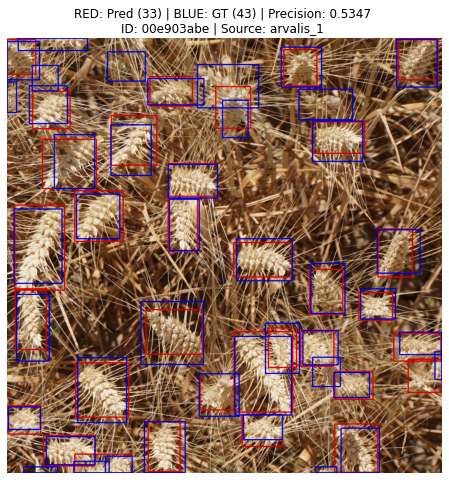

In [ ]:
count=0
pcn=[]
for i in range(len(all_predictions)):
    gt_boxes = all_predictions[i]['gt_boxes'].copy()
    pred_boxes = all_predictions[i]['pred_boxes'].copy()
    scores = all_predictions[i]['scores'].copy()
    image_id = all_predictions[i]['image_id']

    indexes = np.where(scores>best_score_threshold)
    pred_boxes = pred_boxes[indexes]
    scores = scores[indexes]

    new=marking[marking['image_id']==image_id]['source']
    src=list(set(new))[0]

    img_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
    pcn.append(img_precision)
    
    if i==1:
        show_result(image_id, pred_boxes, gt_boxes, src, img_precision)

    if img_precision<0.5:
        if count<0:
            show_result(image_id, pred_boxes, gt_boxes, src, img_precision)
        count+=1

print(count)
print(f'Percentage of Val: {(100*count/i):.2f}%')

mean: 0.7242
median: 0.7313


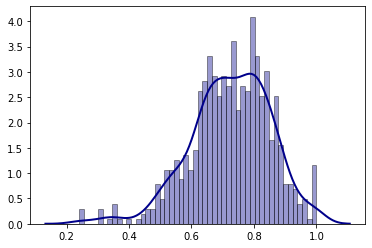

In [ ]:
print("mean: {:.4f}".format(np.mean(pcn)))
print("median: {:.4f}".format(np.median(pcn)))
sns.distplot(pcn, hist=True, kde=True,
             bins=50, color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});